# Chapter 05. Linear Systems: Direct Methods
Based on the Matlab files for the book A First Course in Numerical Methods, by Ascher and Greif.
Julia version by Itrat Ahmed Akhter.

In [1]:
using PyPlot

The following functions are helper functions for the coding examples in Chapter 5

In [2]:
function forsub(A,b,p)
    # Given a unit lower triangular, nonsingular n by n 
    # matrix A, an n-vector b, and a permutation p,
    # return vector y which solves Ay = Pb
    
    n = length(b)
    
    #permute b according to p
    permute!(b,vec(p))
    
    #forward substitution
    y = copy(b)
    for k = 2:n
        multval = A[k,1:k-1]*y[1:k-1]
        y[k] = b[k] - multval[1]
    end
    
    return y
end

function backsub(A,b)
    # Given an upper triangular, nonsingular n by n matrix A
    # and an n-vector b, return vector x which solves Ax = b
    
    n = length(b)
    x = b
    x[n] = b[n]/A[n,n]
    for k = n-1:-1:1
        multval = 0
        for i = k+1:n
            multval = multval + A[k,i]*x[i]
        end
        x[k] = (b[k] - multval) / A[k,k]
    end
    return x
end

function plu(A)
    # Perform LU decomposition with partial pivoting.
    # Upon return the coefficients of L and U replace those
    # of the input n-by-n nonsingular matrix A. The row interchanges
    # performed are recorded in the 1D array p (returned).
   
    n = size(A,1)
    
    # initialize permutation vector p
    p = collect(1:n)
    
    #LU decomposition with partial pivoting
    for k = 1:n-1
        hMat = copy(A)
        for i = 1:size(A,1)
            for j = 1:size(A,2)
                if hMat[i,j] <0
                    hMat[i,j] = -hMat[i,j]
                end
            end
        end
        
        #Find row index of relative maximum in column k
        val,q = findmax((hMat[k:n,k]))
        q = q + k-1
        
        #Interchange rows k and q and record this in p
        A[k,:],A[q,:] = A[q,:],A[k,:]
        p[k],p[q] = p[q],p[k]
        
        #Compute the corresponding column of L
        J = k+1:n
        A[J,k] = A[J,k] / A[k,k]
        
        #Update submatrix by outer product
        A[J,J] = A[J,J] - A[J,k] * A[k,J]
    end
    return p,A
end

function plu_scaled(B)
    #Perform LU decomposition with scaled partial pivoting.
    #Upon return the coefficients of L and U replace those
    #of the input n-by-n nonsingular matrix A. The row interchanges
    #performed are recorded in the 1D array p (returned)
    A = copy(B)
    n = size(A,1)
    
    #find scales, initializes permutation vector p
    s = maxabs(A,2)
    p = collect(1:1:100)
    
    #LU decomposition with partial pivoting
    for k = 1:n-1
        hMat = copy(A)
        for i = 1:size(A,1)
            for j = 1:size(A,2)
                if A[i,j] <0
                    hMat[i,j] = -A[i,j]
                end
            end
        end
        
        #find row index of relative maximum in column k
        divresult = hMat[k:n,k]./s[k:n]
        val,q = findmax(divresult)
    
        q = q+k-1
        
        #interchange rows k and q and record this in p
        A[k,:],A[q,:] = A[q,:],A[k,:]
        p[k],p[q] = p[q],p[k]
        
        #compute the corresponding column of L
        J = k+1:n
        A[J,k] = A[J,k] / A[k,k]
        
        #Update submatrix by outer product
        A[J,J] = A[J,J] - A[J,k] * A[k,J]
    end
    
    return p,A
end

function ainvb(A,b)
    #Solve Ax = b
    
    p,LU = plu(A)
    y = forsub(LU,b,p)
    x = backsub(LU,y)
    return x
end

function ainvb_scaled(A,b)
    #Solve Ax = b
    
    p,LU = plu_scaled(A)
    y = forsub(LU,b,p)
    x = backsub(LU,y)
    return x
end

ainvb_scaled (generic function with 1 method)

# Example 5.11
Comparing scaled and unscaled GEPP for a special example.

In [ ]:
n = 100; h = 1.0/(n-1); K = 100
A = zeros(n,n)
for i = 2:n-1
    A[i,i] = -2/h^2 - K
    A[i,i-1] = -1/h^2
    A[i,i+1] = -1/h^2
end
A[1,1] = 1.0; A[n,n] = 1.0 #end definition of A


xe = ones(Int64,n,1)         #exact solution of 1's
b = A*xe               #corresponding right hand side

#solve using scaled GEPP version ainvb_scaled
xs = ainvb_scaled(A,b)
err_ainvb_scaled = norm(xs-xe)

#solve using ainvb
xu = ainvb(A,b)
err_ainvb = vecnorm(xu-xe)

# Example 5.13
Cholesky for random matrices

In [3]:
n = 500
C = randn(n,n); A = C'*C
xe = randn(n,1) # the exact solution
b = A*xe        # generate right hand side data

R = chol(A)     # Cholesky factor
# the following line is for compatibility with forsub
D = diagm((diag(R)))
L = inv(D) * R' #because for some reason the backslash operator decided not to work in this case
bb = D \ b; p = 1:n
y = forsub(L,bb,p)            # forward substitution R'y = b
x = backsub(R,y)              # backward substitution Rx = y
rerx = norm(x-xe)/norm(xe)     # error by Cholesky 

xd = ainvb(A,b);               # ignore spd and use partial pivoting
rerxd = norm(xd-xe)/norm(xe)   # error by general routine

LoadError: LoadError: MethodError: no method matching *(::Array{Float64,1}, ::Array{Float64,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:138
  *{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},S}(!Matched::Union{Base.ReshapedArray{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},2,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N}}},DenseArray{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},2},SubArray{T<:Union{Complex{Float32},Complex{Float64},Float32,Float64},2,A<:Union{Base.ReshapedArray{T,N,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N}}},DenseArray},I<:Tuple{Vararg{Union{Base.AbstractCartesianIndex,Colon,Int64,Range{Int64}},N}},L}}, ::Union{Base.ReshapedArray{S,1,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N}}},DenseArray{S,1},SubArray{S,1,A<:Union{Base.ReshapedArray{T,N,A<:DenseArray,MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N}}},DenseArray},I<:Tuple{Vararg{Union{Base.AbstractCartesianIndex,Colon,Int64,Range{Int64}},N}},L}}) at linalg/matmul.jl:79
  *(!Matched::Base.LinAlg.AbstractTriangular{T,S<:AbstractArray{T,2}}, ::AbstractArray{T,1}) at linalg/triangular.jl:1496
  ...
while loading In[3], in expression starting on line 11

# Example 5.22 --- Figure 5.8

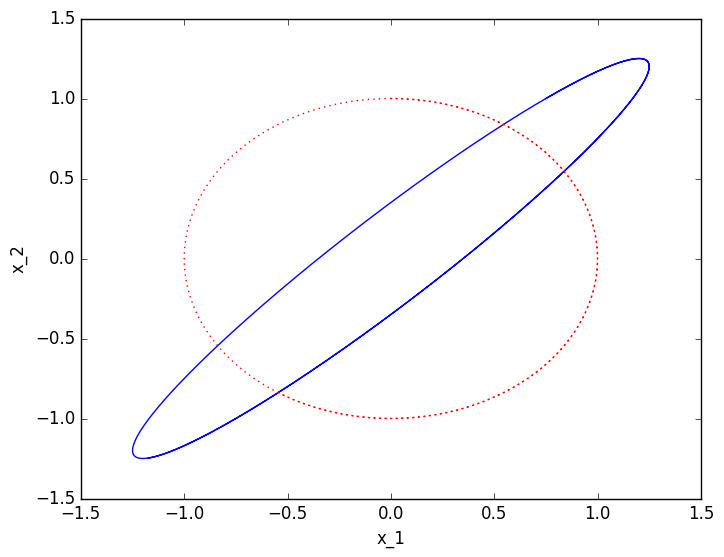

PyObject <matplotlib.text.Text object at 0x317422b50>

In [4]:
d = 0.75
A = [1 d;d 1]
t = 0:.01:10; m = length(t);
x = zeros(2,m)
x[1,1:m] = sin(t);
x[2,1:m] = cos(t);
y = A*x;
plot(vec(y[1,:]),vec(y[2,:]),"b-",vec(x[1,:]),vec(x[2,:]),"r:")
xlabel("x_1")
ylabel("x_2") 

In [17]:
n = 50;
a = randn(n-1)
b = randn(n)
c = randn(n-1)
A = diagm(a,-1) + diagm(b,0) + diagm(c,1);

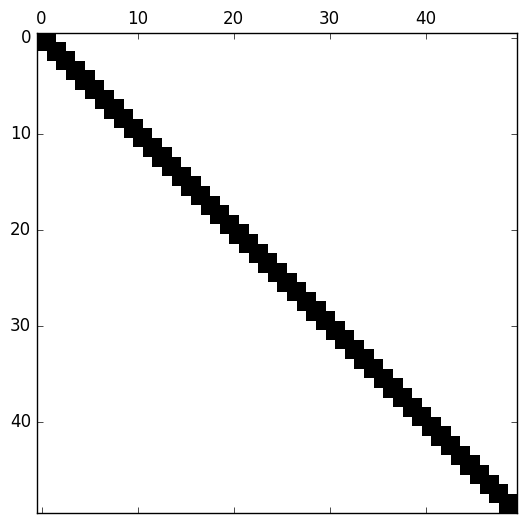

In [19]:
spy(A);

In [7]:
A = sparse(A);
println( nnz(A) )
println( prod(size(A)) )

148
2500


In [8]:
density = nnz(A) / prod(size(A))

0.0592

In [9]:
sparsity = 1-density # close to 1 makes it sparser

0.9408

In [10]:
i, j, v = findnz(A);
for k = 1:nnz(A)
    @printf "%3i  %3i  %10.2e\n" i[k] j[k] v[k]
end

  1    1   -8.27e-01
  2    1   -3.92e-01
  1    2    1.01e+00
  2    2    1.05e+00
  3    2    6.30e-01
  2    3    1.31e+00
  3    3   -3.58e-01
  4    3   -1.82e+00
  3    4   -6.81e-01
  4    4   -4.56e-01
  5    4    3.24e-01
  4    5   -2.40e-01
  5    5   -3.55e-01
  6    5    6.34e-01
  5    6   -1.41e+00
  6    6    7.75e-01
  7    6    2.77e-01
  6    7    4.64e-01
  7    7    4.19e-01
  8    7   -6.26e-01
  7    8    4.92e-01
  8    8    1.42e+00
  9    8   -6.38e-02
  8    9    2.15e-01
  9    9   -3.30e-02
 10    9    8.08e-01
  9   10   -1.69e+00
 10   10    1.89e+00
 11   10    1.21e-01
 10   11   -2.14e+00
 11   11    3.98e-01
 12   11   -3.59e-01
 11   12   -1.08e-01
 12   12    7.31e-01
 13   12    1.31e+00
 12   13    3.07e-01
 13   13    3.82e-01
 14   13    1.24e+00
 13   14    1.02e+00
 14   14   -5.17e-01
 15   14    1.23e+00
 14   15    2.29e-01
 15   15    8.41e-01
 16   15    1.54e+00
 15   16   -9.16e-01
 16   16   -2.50e-01
 17   16    2.95e-01
 16   17    4

In [11]:
#   TRIDISOLVE  Solve tridiagonal system of equations.
#     x = TRIDISOLVE(a,b,c,d) solves the system of linear equations
#     b(1)*x(1) + c(1)*x(2) = d(1),
#     a(j-1)*x(j-1) + b(j)*x(j) + c(j)*x(j+1) = d(j), j = 2:n-1,
#     a(n-1)*x(n-1) + b(n)*x(n) = d(n).

function tridisolve(a,b,c,d)
    x = d
    n = length(x)

    # Elimination
    for j = 1:n-1
        μ = a[j]/b[j]
        b[j+1] = b[j+1] - μ*c[j]
        x[j+1] = x[j+1] - μ*x[j]
    end
    
    # Backsolve
    x[n] = x[n]/b[n]
    for j = n-1:-1:1
        x[j] = ( x[j]-c[j]*x[j+1] ) / b[j]
    end
    return x
end;

In [12]:
d = randn(n);
x = A\d;

In [13]:
x1 = tridisolve(a,b,c,d);

In [14]:
norm(x1-x)

5.609541743754931e-14

Could solve this same system two other ways:

In [15]:
T = diagm(a,-1) + diagm(b,0) + diagm(c,+1)
@time x = T\d;

  0.105675 seconds (58.19 k allocations: 2.466 MB)


In [16]:
S = spdiagm((a, b, c), (-1,0,+1), n, n);
@time x = S\d;

  0.000161 seconds (14 allocations: 5.203 KB)


## Reordering sparse matrices

In [ ]:
# Arrow-head matrix
n = 5
a = randn(5); b = randn(5); c = randn(5);
A = diagm(b); A[:,1] = a; A[1,:] = c;
A

In [ ]:
L, U = lu(A)
U

In [ ]:
# reorder
p = n:-1:1
A = A[p,p]

In [ ]:
L, U = lu(A)
U

## Page Rank

In [ ]:
H = [0 0.5 0.5 0 0 0
0 0 0 0 0 0
1/3 1/3 0 0 1/3 0
0 0 0 0 1/2 1/2
0 0 0 1/2 0 1/2
0 0 0 1 0 0]
n=6

In [ ]:
H = 0.6*H + 0.4/6*ones(6,6)

In [ ]:
x = ones(n)/n
for i=1:100
    x = H*x
end
x = x / norm(x)